In [22]:
from functools import partial

import astropy.units as u
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.table import QTable, vstack
from skimage.measure import regionprops, label, regionprops_table
from skimage.color import label2rgb

import sunpy.map

In [23]:
from astropy.io import fits

fits_path = "/Users/priyanujkashyap/Documents/GitHub/KWS24/sunspot_handson/kodai_stara/Wl_19910221T0755.fits"

# Open the FITS file
fits_data = fits.open(fits_path)

# Display the header
header = fits_data[0].header
data = fits_data[0].data

In [24]:
header

SIMPLE  =                    T /image conforms to FITS standard                 
BITPIX  =                  -32 /bits per data value                             
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 4096 /                                                
NAXIS2  =                 4096 /                                                
EXTEND  =                    T /file may contain extensions                     
ORIGIN  = 'KODAIKANAL OBSERVATORY' /                                            
TELESCOP= '6" REFRACTOR'       /                                                
OBJECT  = 'SUN     '           /                                                
PHOTOHEL= 'YES     '           /PHOTOHELIOGRAM                                  
DATE-OBS= '1991-02-21T07:55'   /YYYY-MM-DD HH:MM                                
LAMBDA  = 'WHITE LIGHT'        /WAVELENGTH                                      
CRPIX1  =             2048.0

In [25]:
import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.map
from sunpy.coordinates import frames

In [26]:
coord = SkyCoord(0*u.arcsec, 0*u.arcsec, obstime='1991-02-21 07:55',
                 observer='earth', frame=frames.Helioprojective)

In [27]:
header = sunpy.map.make_fitswcs_header(data, coord,
                                       reference_pixel=[2048,2048]*u.pixel,
                                       scale=[0.63,0.63]*u.arcsec/u.pixel,
                                       telescope='Kodaikanal', instrument='White-light detector',
                                       wavelength=4500*u.angstrom)


In [28]:
maps = sunpy.map.Map(data,header)
maps = [maps.resample((1024, 1024) * u.pix)]


In [29]:
import sys
# Append the directory to your python path using sys
sys.path.append('/Users/priyanujkashyap/Documents/GitHub/KWS24/sunspot_handson/kodai_stara')
# Import the module
from stara import stara

In [30]:
# Intensity_thresh = 5
# area_thresh = 6
# strel_size = 16
# filter_size = 3
# bb = stara_idl(aa, Intensity_thresh, strel_size, area_thresh, filter_size)
# def stara(smap, circle_radius: u.deg = 100*u.arcsec, median_box: u.deg = 10*u.arcsec,
#           threshold=10., limb_filter: u.percent = None):

In [31]:
# def get_even_numbers(numbers):
#     even_numbers = []
#     for number in numbers:
#         if number % 2 == 0:
#             even_numbers.append(number)
#     return even_numbers

# numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# even_numbers = get_even_numbers(numbers)
# print(even_numbers)


In [32]:
segs = list(map(partial(stara, limb_filter=10. * u.percent), maps))

In [33]:
def get_regions(segmentation, smap):
    labelled = label(segmentation)
    if labelled.max() == 0:
        return QTable()

    regions = regionprops_table(labelled, smap.data,
                                properties=["label",
                                            "centroid",
                                            "area",
                                            "min_intensity"])

    regions['obstime'] = Time([smap.date] * regions['label'].size)
    regions['center_coord'] = smap.pixel_to_world(regions['centroid-0'] * u.pix,
                                                  regions['centroid-1'] * u.pix).heliographic_stonyhurst

    return QTable(regions)


print(list(map(get_regions, segs, maps)))

[<QTable length=187>
label ...                        center_coord                      
      ...                         deg,deg,m                        
int64 ...                          SkyCoord                        
----- ... ---------------------------------------------------------
    1 ...    -27.1178689977188,-37.53888171730907,695700000.0035954
    2 ...   -6.9971494741168385,-23.7933249816477,695700000.0009773
    3 ...  -26.865560356825426,-44.04713946535637,695700000.0024574
    4 ... -23.871209339222844,-38.043537993069485,695699999.9978968
    5 ... -26.691800392586742,-52.058501376958546,695699999.9980825
    6 ...  -21.33814463728919,-42.352134633774334,695700000.0007738
    7 ...  -16.403905394491744,-19.951434585007156,695700000.000504
    8 ...  -18.724703284323482,-36.95237998500296,695699999.9948689
    9 ... -15.817961180914267,-22.113274099892383,695700000.0043029
  ... ...                                                       ...
  178 ...     37.1186478393

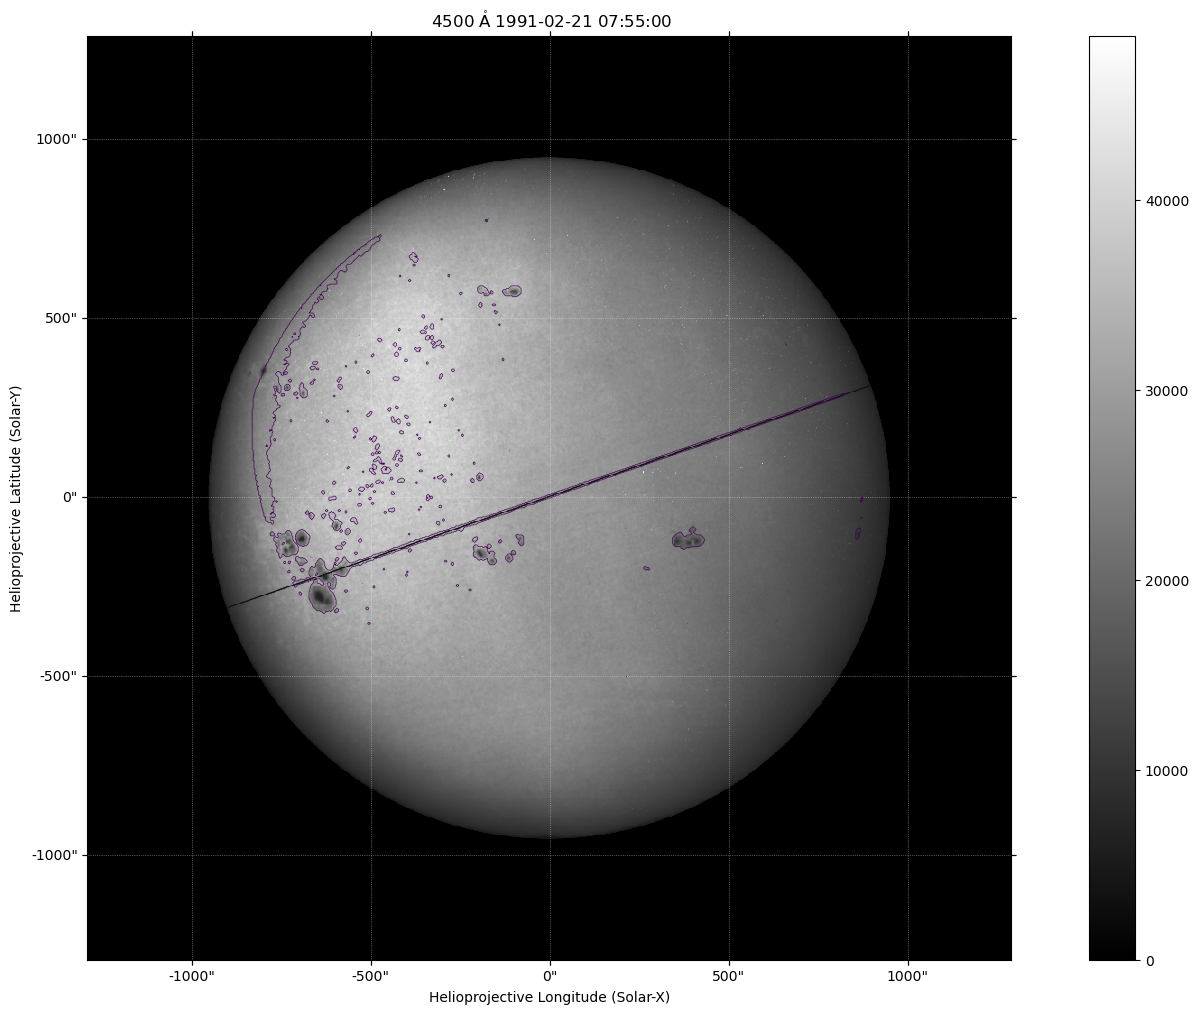

In [34]:
for smap, seg in zip(maps, segs):
  plt.figure(figsize=(20,12))
  ax = plt.subplot(projection=smap)
  smap.plot()
  ax.contour(seg, levels=0,linewidths=0.5)
  plt.colorbar()

plt.show()

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the text file
file_path = '/Users/priyanujkashyap/Documents/GitHub/KWS24/sunspot_handson/kodai_stara/KoSO_sunspot_umbra_area_data_v2.1.txt'
data = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=['Time', 'Latitude', 'Longitude', 'Sunspot_Area', 'Umbral_Area'])

# Convert the 'Time' column to datetime format
data['Time'] = pd.to_datetime(data['Time'])


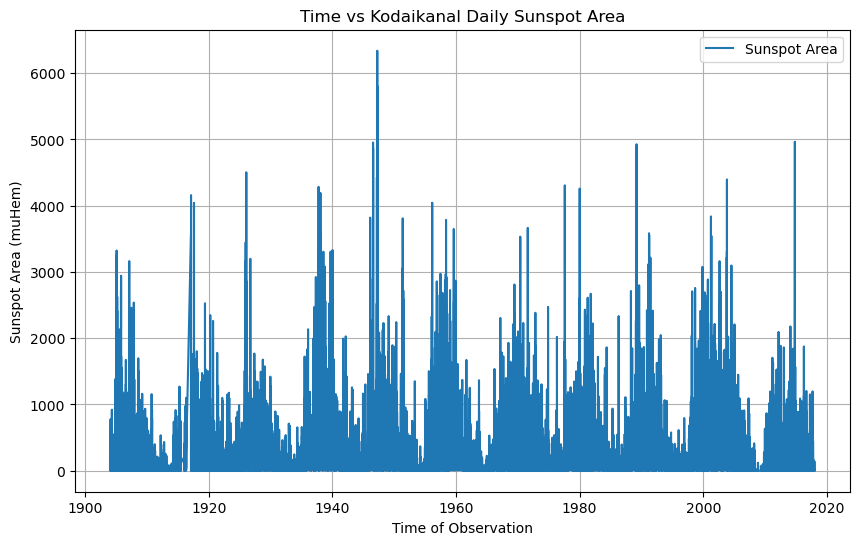

In [36]:

# Plot time vs Sunspot Area
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['Sunspot_Area'], label='Sunspot Area')

# Customize the plot
plt.title('Time vs Kodaikanal Daily Sunspot Area')
plt.xlabel('Time of Observation')
plt.ylabel('Sunspot Area (muHem)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


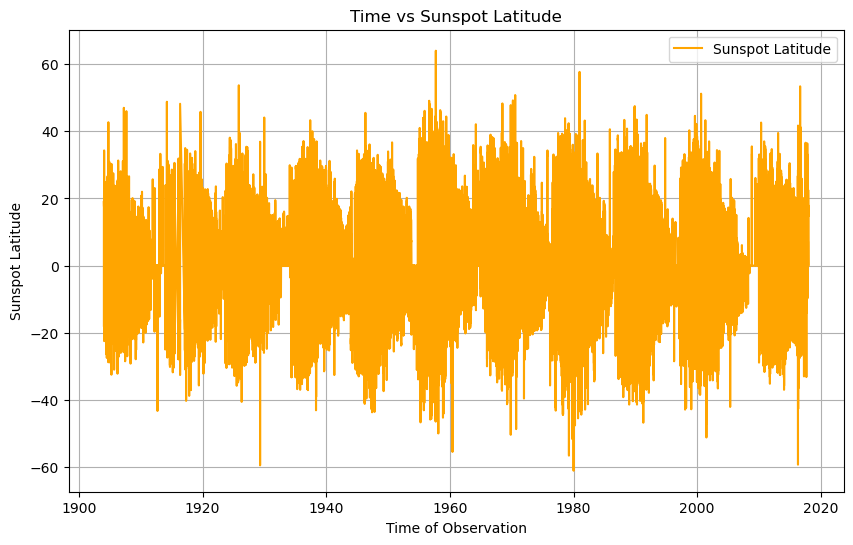

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['Latitude'], label='Sunspot Latitude', color='orange')

# Customize the plot
plt.title('Time vs Sunspot Latitude')
plt.xlabel('Time of Observation')
plt.ylabel('Sunspot Latitude')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

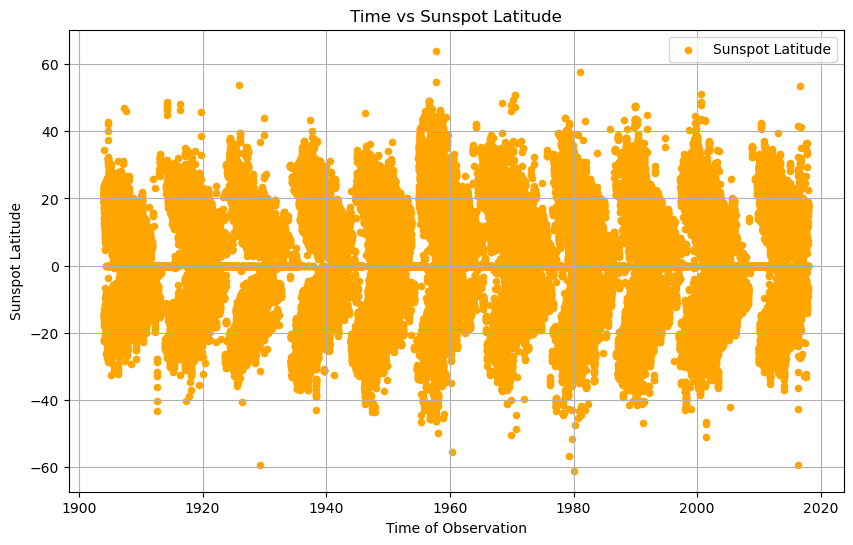

In [38]:
# Plot time vs Sunspot Latitude as data points with circles
plt.figure(figsize=(10, 6))
plt.scatter(data['Time'], data['Latitude'], s=20, marker='o', color='orange', label='Sunspot Latitude')

# Customize the plot
plt.title('Time vs Sunspot Latitude')
plt.xlabel('Time of Observation')
plt.ylabel('Sunspot Latitude')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


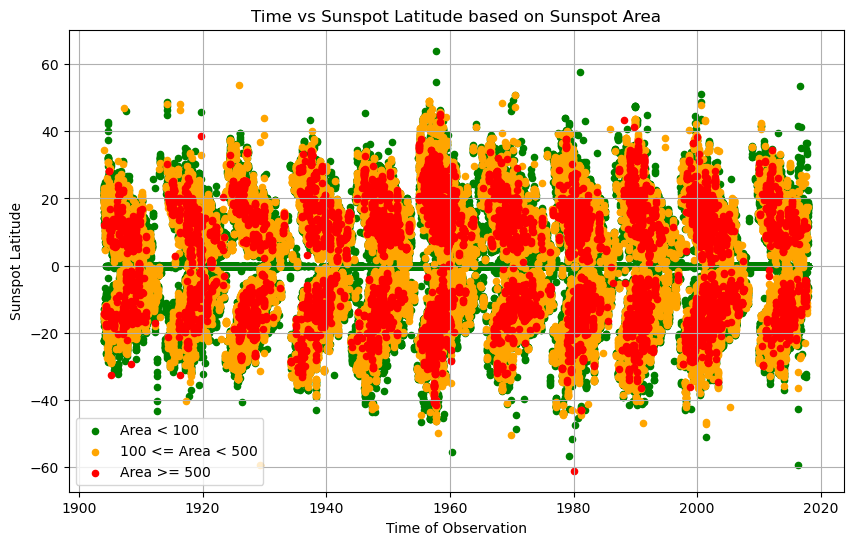

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the text file
file_path = '/Users/priyanujkashyap/Documents/GitHub/KWS24/sunspot_handson/kodai_stara/KoSO_sunspot_umbra_area_data_v2.1.txt'
data = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=['Time', 'Latitude', 'Longitude', 'Sunspot_Area', 'Umbral_Area'])

# Convert the 'Time' column to datetime format
data['Time'] = pd.to_datetime(data['Time'])

# Create masks for different Sunspot Area ranges
area_less_than_100 = data['Sunspot_Area'] < 100
area_between_100_and_500 = (data['Sunspot_Area'] >= 100) & (data['Sunspot_Area'] < 500)
area_greater_than_500 = data['Sunspot_Area'] >= 500

# Plot time vs Sunspot Latitude with different colors for each Sunspot Area range
plt.figure(figsize=(10, 6))

# Plot Sunspot Area less than 100
plt.scatter(data['Time'][area_less_than_100], data['Latitude'][area_less_than_100], s=20, marker='o', color='green', label='Area < 100')

# Plot Sunspot Area between 100 and 500
plt.scatter(data['Time'][area_between_100_and_500], data['Latitude'][area_between_100_and_500], s=20, marker='o', color='orange', label='100 <= Area < 500')

# Plot Sunspot Area greater than 500
plt.scatter(data['Time'][area_greater_than_500], data['Latitude'][area_greater_than_500], s=20, marker='o', color='red', label='Area >= 500')

# Customize the plot
plt.title('Time vs Sunspot Latitude based on Sunspot Area')
plt.xlabel('Time of Observation')
plt.ylabel('Sunspot Latitude')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
